In [1]:
from pyspark.sql.types import StructType, StructField, StringType, LongType
jsonSchema = StructType([
    StructField('label', StringType(), True),
    StructField('tweet_id', LongType(), True),
    StructField('tweet_text', StringType(), True)
])

#replace the file path
df=spark.read.format("json").schema(jsonSchema).load("/Users/Pavel/Documents/KULeuven/Courses/AdvancedAnalyticsinBigDataWorld/spark/data/*")

## Text preprocessing

In [2]:
import pyspark.sql.functions as f
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import ltrim

#Converting all letters to lowercase
df = df.withColumn("tweet_text",f.lower(f.col("tweet_text")))

#removing punctuations, numbers, http and spaces
df =df.withColumn("tweet_text",f.regexp_replace(f.col("tweet_text"),'([^ a-zA-Z\'])',''))
df = df.withColumn("tweet_text",f.regexp_replace(f.col("tweet_text"),'http.*?\\b',' '))
df = df.withColumn("tweet_text",f.ltrim(f.regexp_replace(f.col("tweet_text"),'[\r\n\t\f\v ]+', ' ')))



In [3]:
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover

#Splitting words
tokenizer = Tokenizer(inputCol="tweet_text", outputCol="words")
dataset = tokenizer.transform(df)


In [4]:
#Lemmatization
import nltk
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
#just to try if it works

In [6]:
## Didn't manage to apply lemmatization while using WordNetLemmatizer on pyspark dataframe. 
#So temporarily to make it work, firstly changed to pandas dataframe and then back to pyspark dataframe.

In [5]:
pandas_df = dataset.select("*").toPandas()

In [6]:

pandas_df['lemmatized'] = pandas_df['words'].apply(
                    lambda lst:[lemmatizer.lemmatize(word) for word in lst])
pandas_df['lemmatized']

0        [could, be, a, messan, all, out, war, of, the,...
1        [infectious, disease, designated, bed, drastic...
2                         [do, u, truly, trust, safety, i]
3                                          [do, u, use, q]
4                   [want, but, get, amp, a, dominates, u]
                               ...                        
21177                                          [on, break]
21178                                      [so, bored, of]
21179                                           [get, the]
21180                                         [is, boring]
21181                                          [fuck, you]
Name: lemmatized, Length: 21182, dtype: object

In [7]:
dataset2 = spark.createDataFrame(pandas_df)

In [8]:
#Removing stop words
stopwordList = ["u","ur", "amp"] 
stopwordList.extend(StopWordsRemover().getStopWords())
remover = StopWordsRemover(inputCol="lemmatized", outputCol="filtered" ,stopWords=stopwordList)
dataset2 = remover.transform(dataset2)

In [9]:
#to get rid of words like v, q, wa
dataset2 = dataset2.withColumn("filtered2", f.expr("filter(filtered, x -> not(length(x) < 3))")).where(f.size(f.col("filtered2")) > 0).drop("filtered")
dataset2.show(truncate = False)

+--------------+-------------------+------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------+
|label         |tweet_id           |tweet_text                                                                                                        |words                                                                                                                             |lemmatized                                                                                                                        |filtered2                                                     

In [10]:
dataset2.select("filtered2").show(truncate = False)

+--------------------------------------------------------------------------------------------------------------+
|filtered2                                                                                                     |
+--------------------------------------------------------------------------------------------------------------+
|[messan, war, world]                                                                                          |
|[infectious, disease, designated, bed, drastic, decreasejapan]                                                |
|[truly, trust, safety]                                                                                        |
|[use]                                                                                                         |
|[want, get, dominates]                                                                                        |
|[queen, asia]                                                                                  

## Bag of words

In [11]:
#Vectorizing and IDF

from pyspark.ml.feature import CountVectorizer, StringIndexer, IDF, HashingTF
from pyspark.ml import Pipeline


cv = CountVectorizer(inputCol="filtered2", outputCol="tf_features")
idf = IDF(inputCol = "tf_features", outputCol = "tf_idf_features")
label_stringIdx = StringIndexer(inputCol = "label", outputCol = "labelIndex")

pipeline = Pipeline(stages=[cv, idf, label_stringIdx])

pipelineFit = pipeline.fit(dataset2)
dataset2= pipelineFit.transform(dataset2)
dataset2.show()

+--------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|         label|           tweet_id|          tweet_text|               words|          lemmatized|           filtered2|         tf_features|     tf_idf_features|labelIndex|
+--------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|        #china|1381303111222956033|could be a messan...|[could, be, a, me...|[could, be, a, me...|[messan, war, world]|(36629,[21,140,36...|(36629,[21,140,36...|       2.0|
|      #vaccine|1380298538802765827|infectious diseas...|[infectious, dise...|[infectious, dise...|[infectious, dise...|(36629,[342,619,3...|(36629,[342,619,3...|       1.0|
|      #vaccine|1381494016211030016|do u truly trust ...|[do, u, truly, tr...|[do, u, truly, tr...|[truly, trust, sa...|(36629,[39

## Train and test split

In [12]:
(trainingData2, testData2) = dataset2.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData2.count()))
print("Test Dataset Count: " + str(testData2.count()))

Training Dataset Count: 14718
Test Dataset Count: 6426


## Logistic Regression

In [13]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol = "labelIndex", featuresCol = "tf_idf_features", maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData2)
lrPredictions = lrModel.transform(testData2)

In [14]:
lrPredictions.select("prediction", "labelIndex").show()

+----------+----------+
|prediction|labelIndex|
+----------+----------+
|       2.0|       4.0|
|       2.0|       4.0|
|       4.0|       4.0|
|       1.0|       4.0|
|       0.0|       4.0|
|       0.0|       4.0|
|       4.0|       4.0|
|       0.0|       4.0|
|       4.0|       4.0|
|       4.0|       4.0|
|       4.0|       4.0|
|       0.0|       4.0|
|       4.0|       4.0|
|       0.0|       4.0|
|       4.0|       4.0|
|       1.0|       4.0|
|       4.0|       4.0|
|       4.0|       4.0|
|       4.0|       4.0|
|       0.0|       4.0|
+----------+----------+
only showing top 20 rows



In [15]:
import pyspark.sql.functions as col
lrPredictions.groupBy("prediction").count().orderBy(f.col("count").desc()).show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 2494|
|       1.0| 1641|
|       2.0| 1056|
|       3.0|  642|
|       4.0|  572|
|       5.0|   21|
+----------+-----+



### Evaluation

In [24]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Select (prediction, true label) and compute accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(lrPredictions)
print(accuracy)
print("Test Error = %g " % (1.0 - accuracy))

0.6288515406162465
Test Error = 0.371148 


In [25]:
trainingSummary = lrModel.summary

print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

False positive rate by label:
label 0: 0.04181217555450684
label 1: 0.021555179478044
label 2: 0.0034482758620689655
label 3: 0.0006309148264984228
label 4: 0.0018764659890539485
label 5: 0.0
True positive rate by label:
label 0: 0.9682270191608052
label 1: 0.9553136637066743
label 2: 0.954031117397454
label 3: 0.9421000981354269
label 4: 0.91701244813278
label 5: 0.7967741935483871
Precision by label:
label 0: 0.9001127395715897
label 1: 0.9323455409561084
label 2: 0.9850310332238043
label 3: 0.995850622406639
label 4: 0.9866071428571429
label 5: 1.0
Recall by label:
label 0: 0.9682270191608052
label 1: 0.9553136637066743
label 2: 0.954031117397454
label 3: 0.9421000981354269
label 4: 0.91701244813278
label 5: 0.7967741935483871
F-measure by label:
label 0: 0.9329282542650151
label 1: 0.94368986983588
label 2: 0.9692832764505119
label 3: 0.968229954614221
label 4: 0.9505376344086022
label 5: 0.8868940754039497
Accuracy: 0.9484984372876749
FPR: 0.017821448997847135
TPR: 0.9484984372876

In [26]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics

In [27]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create both evaluators
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")

# Make predicitons
predictionAndTarget = lrPredictions.select("prediction", "labelIndex")

# Get metrics
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(predictionAndTarget)

In [28]:
evaluatorMulti.evaluate(predictionAndTarget) #gives F1 score


0.6301088040574538

In [29]:
print("ACC: %s" % acc)
print("F1 score: %s" % f1)
print("Weighted Precision: %s" % weightedPrecision)
print("Weighted Recall: %s" % weightedRecall)
print("AUC: %s" % auc)

ACC: 0.6288515406162465
F1 score: 0.6301088040574538
Weighted Precision: 0.6691545893842493
Weighted Recall: 0.6288515406162465
AUC: 0.6288515406162465


In [59]:
from sklearn.metrics import confusion_matrix
y_true = lrPredictions.select("labelIndex")
y_true = y_true.toPandas()

y_pred = lrPredictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix


array([[1268,  384,   75,   21,   35,    0],
       [ 459,  958,   37,   13,   22,    0],
       [ 274,  119,  781,   14,   54,    0],
       [ 196,   62,   38,  579,   14,    0],
       [ 232,  106,   99,   15,  435,    1],
       [  65,   12,   26,    0,   12,   20]])

Confusion matrix, without normalization
[[1268  384   75   21   35    0]
 [ 459  958   37   13   22    0]
 [ 274  119  781   14   54    0]
 [ 196   62   38  579   14    0]
 [ 232  106   99   15  435    1]
 [  65   12   26    0   12   20]]


TypeError: object of type 'map' has no len()

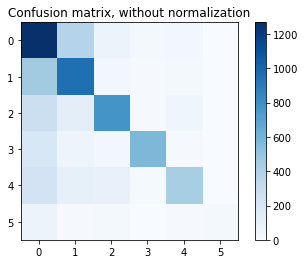

In [60]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.71116096 0.21536736 0.04206394 0.0117779  0.01962984 0.        ]
 [0.30826058 0.64338482 0.02484889 0.00873069 0.01477502 0.        ]
 [0.22061192 0.0958132  0.62882448 0.01127214 0.04347826 0.        ]
 [0.22047244 0.06974128 0.04274466 0.65129359 0.01574803 0.        ]
 [0.26126126 0.11936937 0.11148649 0.01689189 0.48986486 0.00112613]
 [0.48148148 0.08888889 0.19259259 0.         0.08888889 0.14814815]]


TypeError: object of type 'map' has no len()

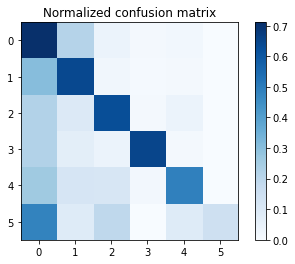

In [61]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')

plt.show()

# Index To String

In [21]:
from pyspark.ml.feature import IndexToString, StringIndexer
converter = IndexToString(inputCol="labelIndex", outputCol="labelOriginal")
converted = converter.transform(lrPredictions)
converterPred = IndexToString(inputCol='prediction',outputCol='labelPredicted',labels=pipelineFit.stages[2].labels)
model = converterPred.transform(converted)